In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import join as oj
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn import metrics
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
#import models
import pickle as pkl
from tqdm import tqdm
from util import train_reg
import config
#df = data.get_tracks() # note: different Xs can be different shapes
#df = data.remove_invalid_tracks(df)
#df = data.preprocess(df)
#df = data.add_outcome(df)
#n = df.shape[0]

/accounts/grad/xsli/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
cell_nums_train = config.SPLIT_ORIG['train'][:5]
cell_nums_test = config.SPLIT_ORIG['train'][5:]

Index(['X', 'X_extended', 'Y', 'X_starts', 'Y_starts', 'X_ends', 'Y_ends',
       'X_pvals', 'Y_pvals', 'catIdx', 'mean_total_displacement',
       'mean_square_displacement', 'lifetime', 'lifetime_extended', 'x_pos',
       'y_pos', 'cell_num', 't', 'x_pos_seq', 'y_pos_seq', 'pid', 'valid',
       'lifetime_ref', 'X_max', 'X_max_extended', 'X_min', 'X_mean', 'X_std',
       'Y_max', 'Y_mean', 'Y_std', 'X_peak_idx', 'Y_peak_idx',
       'X_peak_time_frac', 'slope_end', 'X_peak_last_15', 'X_peak_last_5',
       'rise', 'fall', 'rise_extended', 'fall_extended', 'fall_late_extended',
       'fall_final', 'rise_slope', 'fall_slope', 'rise_local_3',
       'fall_local_3', 'rise_local_11', 'fall_local_11', 'max_diff',
       'min_diff', 'fall_imp', 'y_score', 'y_thresh', 'y', 'y_num_sig',
       'y_single_sig', 'y_double_sig', 'y_conservative_thresh', 'y_consec_sig',
       'y_sig_min_diff', 'y_consec_thresh', 'sig_idxs', 'hotspots',
       'Y_peak_time_frac', 'y_z_score', 'X_max_around_Y_pe

### Max strength prediction

In [8]:
df = data.get_data(dset='orig')
df = df[df['valid'] == 1] 
df = train_reg.log_transforms(df)

In [13]:
def add_sig_mean(df):
    sig_mean = []
    for i in range(len(df)):
        sigs = np.array(df['Y_pvals'].iloc[i]) < 0.05
        if sum(sigs)>0:
            sig_mean.append(np.mean(np.array(df['Y'].iloc[i])[sigs]))
        else:
            sig_mean.append(0)
    df['Y_sig_mean'] = sig_mean
    return df

In [29]:
df_train = df[df.cell_num.isin(config.DSETS['orig']['train'])] 
df_test = df[df.cell_num.isin(config.DSETS['orig']['test'])] 

In [18]:
#dfs = {}
dfs['clath_gak'] = data.get_data(dset='clath_gak', use_processed=False)
#df_new = df_new[df_new['valid'] == 1] 

loading + preprocessing data...
	loading tracks...
	 processed/tracks_clath_gak.pkl /scratch/users/vision/data/abc_data/auxilin_new_data/AI_Clathrin_molecularPrediction/CLTA-TagRFP+-+ EGFP-GAK-A8+-+  TIRF data
CLTA-TagRFP EGFP-GAK A8/1
CLTA-TagRFP EGFP-GAK A8/2


/accounts/grad/xsli/abc-image-understanding/data.py:162: RuntimeWarning: All-NaN axis encountered
  msd.append(np.nanmax(tracks['MotionAnalysis'][i]['MSD']))


CLTA-TagRFP EGFP-GAK A8/3
CLTA-TagRFP EGFP-GAK A8/4
CLTA-TagRFP EGFP-GAK A8/5
CLTA-TagRFP EGFP-GAK A8/6
CLTA-TagRFP EGFP-GAK A8/7
CLTA-TagRFP EGFP-GAK A8/8
CLTA-TagRFP EGFP-GAK A8/9
	preprocessing data...
	adding features...


In [21]:
for dset in ['clath_aux+gak_new', 'clath_gak']:
    dfs[dset] = dfs[dset][dfs[dset]['valid'] == 1] 
    dfs[dset] = add_sig_mean(dfs[dset])
    test_res = train_reg.test_reg(dfs[dset], feat_names=feat_names, model=m['model'], outcome_def=outcome_def)
    print(test_res)

{'preds': array([ 62.68855886, 210.57659424, 274.09825935, ..., 139.71821848,
       206.56125573, 329.4579262 ]), 'r2': 0.202620258254536, 'pearsonr': (0.46758662923483546, 0.0)}
{'preds': array([167.5350078 ,  91.69487631, 179.2669814 , ..., 709.26775303,
       410.88288271, 226.22987435]), 'r2': 0.09840886581763675, 'pearsonr': (0.4495873287086709, 0.0)}


In [ ]:
df_new_all = data.get_data(dset='clath_aux')
#df_new = df_new[df_new['valid'] == 1] 

In [4]:
np.mean(df_new_all['Y_max'])

1013.9647249817708

In [13]:
df_new = df_new[df_new.cell_num.isin(config.DSETS['clath_aux']['train'])]

In [42]:
df_new = train_reg.log_transforms(df_new)

/accounts/grad/xsli/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
len(df_train), len(df_test), len(df_new)

(3067, 1047, 7643)

In [70]:
df_new.lifetime.max()

187

In [7]:
outcome_def = 'Y_sig_mean'
out_dir = 'results/regression/May5'
os.makedirs(out_dir, exist_ok=True)
feat_names_log = ['X_95_quantile_log', 'X_mad_log', 
              'total_displacement','mean_square_displacement', 'lifetime', 
              'rise_log', 'fall_log', 'rise_local_3_log', 'rise_local_11_log', 
                  'fall_local_3_log', 'fall_local_3_log']
feat_names = data.get_feature_names(dfs['clath_aux+gak_new'])
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max',
                           'X_max_around_Y_peak', 'X_max_after_Y_peak']
              and not x.startswith('pc_')
              and not 'log' in x
              and not 'binary' in x
#               and not 'slope' in x
             ]
#print(feat_names)

In [114]:
for model_type in tqdm(['linear', 'gb', 'rf', 'svm', 'ridge']):
    out_name = f'{model_type}'
                    #print(out_name)
    train_reg.train_reg(df_train, feat_names=feat_names, model_type=model_type, 
                 outcome_def=outcome_def,
                 out_name=f'{out_dir}/{out_name}.pkl')    

100%|██████████| 5/5 [00:57<00:00,  8.66s/it]


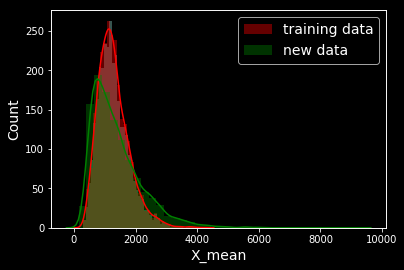

In [173]:
ax = sns.distplot(df_train['X_mean'], kde=False)
ax2 = ax.twinx()
sns.distplot(df_train['X_mean'], ax=ax2, hist=True, kde=True, 
             bins=int(180/5), color='red', label='training data')
ax2.set_yticks([])
sns.distplot(df_new['X_mean'], hist=True, kde=True, 
             bins=int(180/5), color='green', label='new data')
#plt.xlim((0, 10000))
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel('X_mean', fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

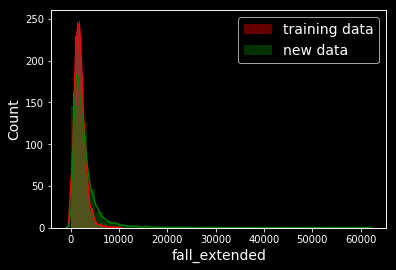

In [172]:
ax = sns.distplot(df_train['fall_extended'], kde=False)
ax2 = ax.twinx()
sns.distplot(df_train['fall_extended'], ax=ax2, hist=True, kde=True, 
             bins=int(180/5), color='red', label='training data')
ax2.set_yticks([])
sns.distplot(df_new['fall_extended'], hist=True, kde=True, 
             bins=int(180/5), color='green', label='new data')
#plt.xlim((0, 10000))
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel('fall_extended', fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

In [164]:
np.median(df_new[outcome_def][df_new[outcome_def]>0])

1562.3242307945743

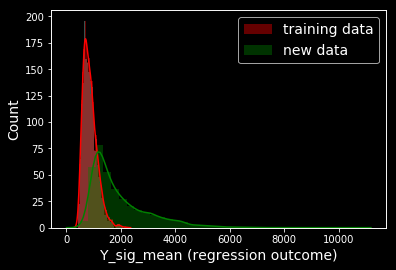

In [175]:
ax = sns.distplot(df_train[outcome_def][df_train[outcome_def]>0], kde=False)
ax2 = ax.twinx()
sns.distplot(df_train[outcome_def][df_train[outcome_def]>0], ax=ax2, hist=True, kde=True, 
             bins=int(180/5), color='red', label='training data')
ax2.set_yticks([])
sns.distplot(df_new[outcome_def][df_new[outcome_def]>0], hist=True, kde=True, 
             bins=int(180/5), color='green', label='new data')
#plt.xlim((0, 10000))
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel('Y_sig_mean (regression outcome)', fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

In [178]:
np.mean(df_train['Y_max'])

823.7976231768818

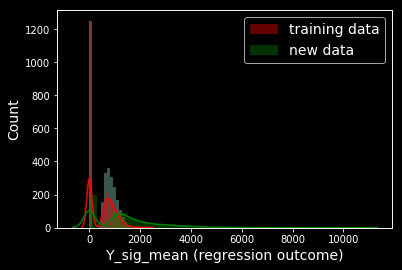

In [176]:
ax = sns.distplot(df_train[outcome_def], kde=False)
ax2 = ax.twinx()
sns.distplot(df_train[outcome_def], ax=ax2, hist=True, kde=True, 
             bins=int(180/5), color='red', label='training data')
ax2.set_yticks([])
sns.distplot(df_new[outcome_def], hist=True, kde=True, 
             bins=int(180/5), color='green', label='new data')
#plt.xlim((0, 10000))
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel('Y_sig_mean (regression outcome)', fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

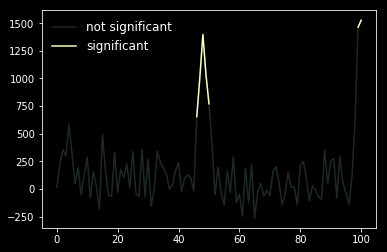

In [148]:
sigs = np.array(df_train['Y_pvals'].iloc[0]) < 0.05
df_train['Y'].iloc[0]
sig_frames = [df_train['Y'].iloc[0][i] if sigs[i] else np.nan for i in range(len(sigs))]
plt.plot(df_train['Y'].iloc[0], alpha=.2, label='not significant')
plt.plot(sig_frames, label='significant')
plt.legend(frameon=False, fontsize=12)

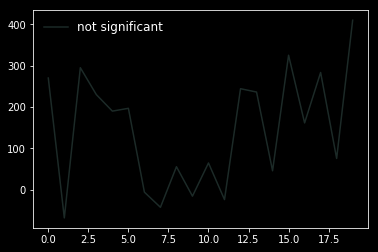

In [150]:
k = 1
sigs = np.array(df_train['Y_pvals'].iloc[k]) < 0.05
#df_train['Y'].iloc[k]
sig_frames = [df_train['Y'].iloc[0][i] if sigs[i] else np.nan for i in range(len(sigs))]
plt.plot(df_train['Y'].iloc[k], alpha=.2, label='not significant')
plt.plot(sig_frames, label='significant')
plt.legend(frameon=False, fontsize=12)

In [133]:
df_new1 = df_new[df_new.cell_num.isin(np.array(['CLTA-TagRFP EGFP-Aux1-A7D2 EGFP-GAK-F6/5']))]

In [128]:
df_new.cell_num.values[:5]

array(['CLTA-TagRFP EGFP-Aux1-A7D2 EGFP-GAK-F6/10',
       'CLTA-TagRFP EGFP-Aux1-A7D2 EGFP-GAK-F6/10',
       'CLTA-TagRFP EGFP-Aux1-A7D2 EGFP-GAK-F6/10',
       'CLTA-TagRFP EGFP-Aux1-A7D2 EGFP-GAK-F6/10',
       'CLTA-TagRFP EGFP-Aux1-A7D2 EGFP-GAK-F6/10'], dtype=object)

In [3]:
import pandas as pd
out_dir = 'results/regression/May5'
out_name=f'{out_dir}/rf.pkl'
m = pd.read_pickle(out_name)
m['model']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [13]:
fi = m['model'].feature_importances_.round(3)
m['model']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [15]:
test_res = train_reg.test_reg(dfs['clath_aux+gak_new'], feat_names=feat_names, model=m['model'], outcome_def=outcome_def)

In [17]:
test_res

{'preds': array([ 62.68855886, 210.57659424, 274.09825935, ..., 139.71821848,
        206.56125573, 329.4579262 ]),
 'r2': 0.202620258254536,
 'pearsonr': (0.46758662923483546, 0.0)}

Text(0, 0.5, 'Residual')

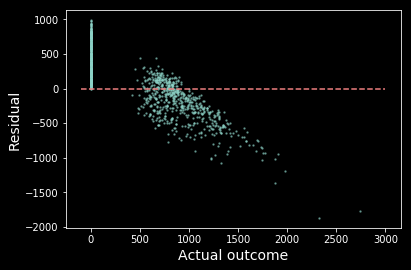

In [55]:
plt.scatter(df_test[outcome_def], test_res['preds'] - df_test[outcome_def], alpha=.5, s=2)
#plt.plot([0, 1500], [0, 1500], '--', color='lightcoral', label='y=x')
plt.plot([-100, 3000], [0, 0], '--', color='lightcoral')
plt.xlabel("Actual outcome", fontsize=14)
plt.ylabel("Residual", fontsize=14)

In [8]:
test_res = train_reg.test_reg(df_new, feat_names=feat_names, model=m['model'], outcome_def=outcome_def)

NameError: name 'df_new' is not defined

In [53]:
test_res

{'preds': array([334.08666181, 913.78307292, 181.86450339, ..., 266.20459515,
        516.34154364, 593.96167738]),
 'r2': -0.31290332237272067,
 'pearsonr': (0.553917333717159, 0.0)}

Text(0, 0.5, 'Residual')

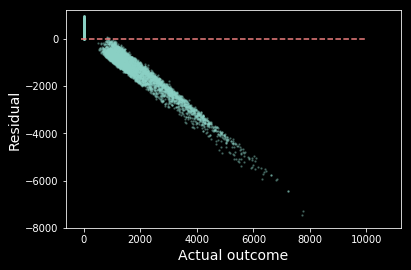

In [58]:
plt.scatter(df_new[outcome_def], test_res['preds']-df_new[outcome_def], alpha=.3, s=2)
plt.ylim((-8000, 1200))
plt.plot([-100, 10000], [0, 0], '--', color='lightcoral')
plt.xlabel("Actual outcome", fontsize=14)
plt.ylabel("Residual", fontsize=14)

In [116]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['pearsonr'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r['pearsonr']
#r.style.background_gradient(cmap='binary', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

model_type
rf        0.588
gb        0.577
ridge     0.537
linear    0.537
svm       0.461
Name: pearsonr, dtype: float64

Text(0, 0.5, 'r2')

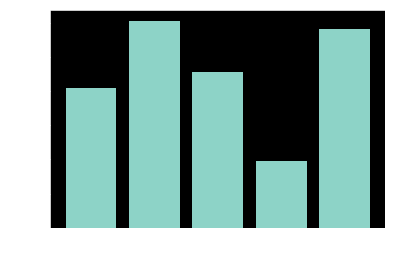

In [33]:
plt.bar(range(1, 6), r['cv_accuracy_by_cell'][0])
plt.xlabel('cell')
plt.ylabel('r2')

# basic eda

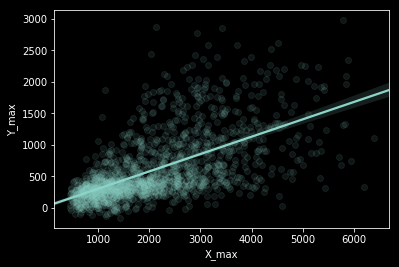

In [18]:
sns.regplot('X_max', 'Y_max', df, scatter_kws={'alpha': 0.1})

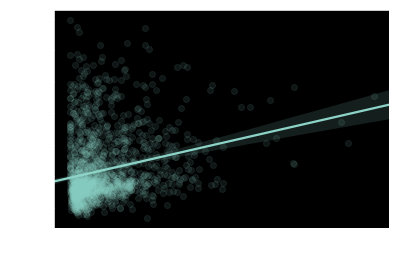

In [3]:
sns.regplot('totalDisplacement', 'Y_max', df, scatter_kws={'alpha': 0.1})

In [34]:
m = RidgeCV(store_cv_values=True)
m.fit(df['X_max'].values.reshape(-1, 1), df['Y_max'].values.reshape(-1, 1), )

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=True)

In [37]:
m.cv_values_[0]

array([[9359.74290596, 9359.74286412, 9359.74244571]])

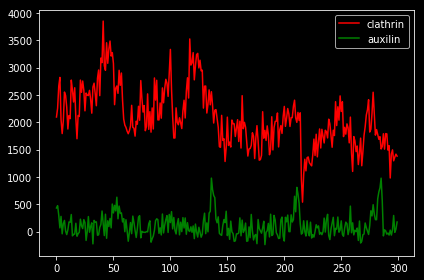

In [91]:
# 0 is the first channel (clathrin)
R, C = 1, 1
# R, C = 5, 5
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    plt.plot(row.X, color='red', label='clathrin')
    plt.plot(row.Y, color='green', label='auxilin')
#     plt.axi('off')
plt.legend()

plt.tight_layout()
plt.show()

# fit maxconv

In [2]:
# pad lists with zeros
X_mat = data.extract_X_mat(df)
Y_max = df['Y_max'].values.astype(np.float32)
Y_max -= np.min(Y_max)
Y_max /= np.std(Y_max) # zero min, stddev 1
# X_feat, Y_max = data.extract_single_pixel_features(X, Y)
# Y_max -= np.min(Y_max) # make all vals positive
# print('shapes', X_feat.shape, Y_max.shape)

# m.fit(X_feat, Y_max)
X_train, X_test, Y_train, Y_test = train_test_split(X_mat, Y_max, test_size=0.33, random_state=42)
# results = cross_validate(m, X_feat, y_max, cv=2, return_train_score=True, return_estimator=True)

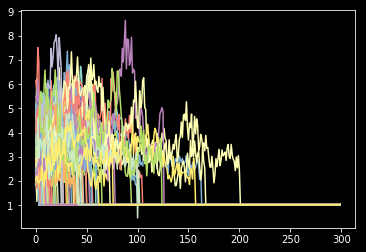

In [15]:
for i in range(100):
    plt.plot(X_train[i])

In [16]:
conv_size = 10
num_channels = 1
dirname = oj('out', f'conv_size={conv_size}_num_channels={num_channels}')
# dirname = 'conv_size=8_num_chanels=30' # conv_size x num_conv
# train_end_cp = TrainEndCheckpoint(dirname='exp1')
# net = NeuralNetClassifier(
#     MyModule, lr=0.5, callbacks=[cp, train_end_cp]
# )

net = NeuralNetRegressor(
    models.MaxConv(num_units=num_channels, kernel_size=conv_size, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

In [ ]:
# train
net.fit(X_train, Y_train.reshape(-1, 1))
# pkl.dump(net, open( "net_big.pkl", "wb" ))

Re-initializing optimizer.
(10,)
offset 0.15514989


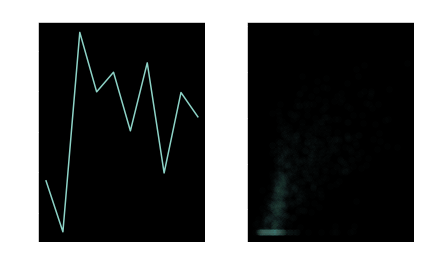

In [31]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 2

ws = net.module_.state_dict()['conv1.weight'].cpu().numpy().squeeze()
print(ws.shape)
print('offset', net.module_.state_dict()['offset'].cpu().numpy().squeeze())

plt.subplot(R, C, 1)
plt.title('filters')
plt.plot(ws.T)

plt.subplot(R, C, 2)
preds = net.predict(X_train)
plt.plot(Y_train, preds, 'o', alpha=0.01)
plt.title(f'mse {np.mean(np.square(Y_train - preds)):0.2f} r2 {metrics.r2_score(Y_train, preds):0.2f}')
plt.xlabel('Y')
plt.ylabel('pred')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()